<a href="https://colab.research.google.com/github/yuvalofek/FrequentistML/blob/master/NonNegativeMatrixFactorizationFreqML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-Negative Matrix Factorization 


---

Yuval Epstain Ofek and Theo Jaquenoud

**The Prompt:**


Select a basic, explicit feedback dataset, many examples here: 

https://gist.github.com/entaroadun/1653794

And use the Surpise library:

http://surpriselib.com/

To implement a basic recommendation system. Many of those datasets are already loaded into the Surpise package to make this easy. You should tune and cross validate your system to select the best values for the # of latent dimensions, the regularization parameter, and any other hyperparameters.

Stretch Goal #1 (3 points)

Using an explicit feedback dataset, implement the NMF algorithm by hand, tune it via cross validation to select the # of latent dims and regularzation parameter

Stretch goal #2 (3 points)

Using an implicit feedback dataset, some can be found here:

https://cseweb.ucsd.edu/~jmcauley/datasets.html

And implement the implicit feedback version of NMF. Evaluating performance will be harder however, so instead of doing a grid seach and tuning, try to output the ratings explanations (i.e. use eqn 7 of the implicit feedback dataset). Warning: I've never assigned this particular stretch goal before so I dont know how hard this one will be.

**TLDR:**


*   Select basic explicit feedback dataset
*   Import Suprise
*   Implement a basic recommendation system
*   Cross validate
*   Tune # of latent dims, regularization, & other hyperparams

Stretch Goals:
*   Implement NMF by hand 
*   Cross validate
*   Tune # of latent dims, regularization, & other hyperparams


2nd Stretch Goal:
* Repeat stretch goal 1 with an IMPLICIT feedback dataset




## Main Project

In [ ]:
#install 
!pip install scikit-surprise

In [ ]:
#import stuff
import numpy as np
import pandas as pd

from surprise import Dataset, Reader, NMF, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
#from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import sys

In [ ]:
#Get dataset:
data = Dataset.load_builtin('ml-100k', prompt = False)

header = ['user_id', 'item_id', 'rating', 'timestamp']
df_data = pd.DataFrame(data.raw_ratings, columns=header)
df_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
#Getting movie names
itemurl = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'
item_names = ["iid", "movie title", "release date", "video release date",
"IMDb URL", "unknown", "Action", "Adventure", "Animation",
"Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
"Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
"Thriller", "War", "Western"]
items = pd.read_csv(itemurl,
                    encoding='cp1250',
                    header = None,
                    delimiter='|')
items.columns = item_names



In [ ]:
params = {
    "n_factors": np.linspace(1, 10, num=3, dtype=int),
    "n_epochs": [5,10],
    "reg_pu": np.logspace(-2, 0, num=3, dtype=float),
    "reg_qi": np.logspace(-2, 0, num=3, dtype=float)
}
grid = GridSearchCV(NMF, params, measures=['rmse'], cv=3, n_jobs=-1, joblib_verbose = 1)


grid.fit(data)
print('Best score: {}'.format(grid.best_score['rmse']))
print('Parameters:')
print(grid.best_params['rmse'])
algo = grid.best_estimator['rmse']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min


Best score: 0.9764917010202256
Parameters:
{'n_factors': 5, 'n_epochs': 5, 'reg_pu': 0.1, 'reg_qi': 1.0}


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  5.2min finished


In [ ]:
trainset = data.build_full_trainset()

algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)


In [ ]:
pred = pd.DataFrame(predictions)
pred['iid'] = pred['iid'].astype('int')
merged = pd.merge(pred, items[['iid', 'movie title']], on= 'iid')
merged.drop(['iid', 'details'], axis = 1, inplace=True)

names = ['UserID', 'Rating', 'Estimated Rating', 'Movie Title']
merged.columns = names
merged.sort_values('UserID', inplace=True)
merged

,UserID,Rating,Estimated Rating,Movie Title
694556,1,3.52986,2.548265,Tales from the Crypt Presents: Bordello of Blo...
810066,1,3.52986,3.334686,Mrs. Parker and the Vicious Circle (1994)
1433246,1,3.52986,4.239117,My Favorite Season (1993)
1292198,1,3.52986,1.919555,Here Comes Cookie (1935)
1315684,1,3.52986,1.558703,Naked in New York (1994)
...,...,...,...,...
1078426,99,3.52986,2.318623,Senseless (1998)
559719,99,3.52986,2.609442,Batman & Robin (1997)
1450128,99,3.52986,3.101678,Scream of Stone (Schrei aus Stein) (1991)
581901,99,3.52986,2.317030,McHale's Navy (1997)


## Implementing SGD NMF

In [ ]:
class sgd_nmf:
  
  def __init__(self, n_latent_dims=3, lmbda=0.1, learning_rate=0.001, n_epochs=200):
    self.n_epochs = n_epochs
    self.n_latent_dims = n_latent_dims
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def N(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    #center gaussian about average rating for a 1-5 scale (1+2+3+4+5)/5 = 3
    self.Q = 3 * np.random.rand(self.n_latent_dims, n) 
    self.P = 3 * np.random.rand(self.n_latent_dims, m)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.N(self.P[:,u], self.Q[:,i])
            self.Q[:, i] += self.learning_rate * (error * self.P[:,u] - self.lmbda * self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:,i] - self.lmbda * self.P[:,u])

        train_rmse = rmse(self.N(self.P, self.Q), X_train)
        val_rmse = rmse(self.N(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.N(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]

    return y_hat[user_index, predictions_index].flatten()

In [ ]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

This train_test_split function removes certain user ratings from the data in order to create a sparser matrix and basically simulate the "cold start" problem or deal with missing ratings

In [ ]:
# train - test split
def train_test_split(ratings, percs = [0.8, 0.2]):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        val_ratings = np.random.choice(ratings[user,:].nonzero()[0],
                                        size = round(len(ratings[user,:].nonzero()[0]) * percs[1]),
                                        replace=False
                                        )
        train[user, val_ratings] = 0
        validation[user, val_ratings] = ratings[user, val_ratings]
    
    return train, validation

We can interpret this sample matrix (small to make it readable) as the ratings a given user (rows) gives to a particular movie (columns)

In [ ]:
R = np.array([
    [5, 3, 0, 1, 5],
    [4, 0, 0, 1, 4],
    [1, 1, 0, 5, 2],
    [1, 0, 0, 4, 0],
    [0, 1, 5, 4, 0],
    ])

In [ ]:
X_train, X_val = train_test_split(R)
print(R)
print(X_train)
print(X_val)

[[5 3 0 1 5]
 [4 0 0 1 4]
 [1 1 0 5 2]
 [1 0 0 4 0]
 [0 1 5 4 0]]
[[5 3 0 1 0]
 [4 0 0 0 4]
 [0 1 0 5 2]
 [1 0 0 4 0]
 [0 1 0 4 0]]
[[0. 0. 0. 0. 5.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0.]]


[4, 0.15, 0.003]


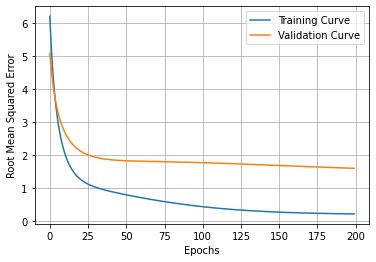

In [ ]:
# def __init__(self, n_latent_dims=3, lmbda=0.1, learning_rate=0.001, n_epochs=200):

dims = [2,3,4]
lds = [0.05, 0.1, 0.15, 0.2]
lrs = [0.001, 0.002, 0.003, 0.004]

best_params = [0,0,0]
best_MSE = float("inf")
best_model = sgd_nmf()

#print(MSE<sys.maxsize)

for dim, ld, lr in zip(dims, lds, lrs):
  my_nmf = sgd_nmf(n_latent_dims = dim, lmbda=ld, learning_rate=lr)
  my_nmf.fit(X_train, X_val)
  if my_nmf.val_error[-1] < best_MSE:
    best_params = [dim,ld,lr]
    best_model = my_nmf
    best_MSE = my_nmf.val_error[-1]

print(best_params)
plt.plot(range(my_nmf.n_epochs), best_model.train_error, label='Training Curve');
plt.plot(range(my_nmf.n_epochs), best_model.val_error, label='Validation Curve');
plt.xlabel('Epochs');
plt.ylabel('Root Mean Squared Error');
plt.legend()
plt.grid()
plt.show()